In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import time
import copy
import calc_vector
import multiprocessing as mp
import random
import tensorflow as tf

# pd.set_option('display.max_columns', 100)

In [2]:
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

# Read Data

In [3]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'

## Amazon Fashion

In [4]:
data_path = 'data/Amazon/'
# file_name = 'Amazon_full' 
# file_name = 'Amazon_05_users' 
file_name = 'Amazon_01_users'
# file_name = 'Amazon_005_users'
# file_name = 'Amazon_001_users'

## MovieLens

In [5]:
# data_path = 'data/ML/'
# file_name = 'ML_full' 
# file_name = 'ML_05_users'
# file_name = 'ML_01_users'
# file_name = 'ML_005_users'
# file_name = 'ML_001_users'

In [6]:
df = pd.read_pickle(path + data_path + file_name)
df.head()

,user,item,datetime,rating,item_id,user_id
4983863,A39ZLL8ILVT2J8,B00FXSELCM,2014-03-24,3.0,155390,730619
7294092,A39ZLL8ILVT2J8,B00VDPQ884,2016-06-29,5.0,264632,730619
4809981,A39ZLL8ILVT2J8,B00EWC0W3W,2016-08-14,5.0,147315,730619
9337932,A39ZLL8ILVT2J8,B01EZKMD64,2016-10-03,5.0,362038,730619
8832820,A39ZLL8ILVT2J8,B01ABS4646,2016-12-22,5.0,335911,730619


# Data Prep
Create new ids for users and items that match the row and column indices of the user-item interaction matrix

In [7]:
df['item_id'] = df.item.astype('category').cat.codes
df['user_id'] = df.user.astype('category').cat.codes

## Train Test Split
### Leave last item out of subset of users

In [8]:
def leave_users_out(full_data, leave_out, seed=1234):
    np.random.seed(seed)
    full_data['index'] = full_data.index
    user_index_df = full_data.groupby('user')['index'].apply(list)
    users = np.random.choice(list(user_index_df.index), leave_out, replace=False)
    users_indices = []
    
    for user in users:
        users_indices.extend(user_index_df.loc[user])
    
    sub_set = full_data.loc[users_indices]
    remaining = full_data.drop(users_indices)
    
    return remaining.drop(columns=['index']), sub_set.drop(columns=['index'])

In [9]:
def leave_last_x_out(full_data, n_users, leave_out=1, seed=1234):
    # Input: data must contain user_id
    # Output: full_data = without all last (time order) entries in leave one out set
    #         leave_one_out_set = data with one user and one item from full_data
    np.random.seed(seed)
    
    full_data['index'] = full_data.index
    user_items_ind = full_data.groupby('user_id')['index'].apply(list)
    users = full_data.user_id.unique()
    leave_out_indices = []
    users_picked = []
    
    for i in range(n_users):
        random_user = np.random.choice(users)
        item_indices = user_items_ind[random_user] # random user's items indices
        while random_user not in users_picked and len(item_indices) <= leave_out: # needs to have more items than to leave out, or deleting users
            random_user = np.random.choice(users)
            item_indices = user_items_ind[random_user]
            
        users_picked.append(random_user)
        leave_out_indices.extend(item_indices[-leave_out:])
    
    leave_out_set = full_data.loc[leave_out_indices] # the last items of n_users users with n_item > leave_out
    full_data_leave_one_out = full_data.drop(leave_out_indices) # drops last items for n_users users
    
    return full_data_leave_one_out.drop(columns=['index']), leave_out_set.drop(columns=['index'])

In [23]:
def train_val_test_split(df, batch_size, val_perc, test_perc, n_items_val, n_items_test, stats=True):
    # Input: df with user and item id, batch size for CFRNN data, val and test perc of users
    #        number of last items to leave out for val and test set
    # Output:full_data = total users and items of the original df, 
    #        Train, validation and test sets
    
    total_users = len(df.user_id.unique()) # Need all users for BPR
    total_items = len(df.item_id.unique()) # Need all items for CFRNN
    
    users_to_remove = len(df.user_id.unique())%batch_size #Batch size compatible for CFRNN
    df_new, deleted_users = leave_users_out(df, users_to_remove)

    test_users = int(test_perc*total_users) # Number of users to be used for testing
    test_last_items = n_items_test # Items to be removed from test users in train set and used in test set

    val_users = int(val_perc*total_users)
    val_last_items = n_items_val
    
    train_set, test_set = leave_last_x_out(df_new, test_users, test_last_items)
    train_set, val_set = leave_last_x_out(train_set, val_users, val_last_items)
    
    if stats:
        print('Total number of items:', total_items)
        print('Total users:', total_users)
        print('Number of train users:', len(train_set.user_id.unique()))
        print('Number of test users:', test_users)
        print('Number of validation users:', val_users, '\n')
        print('Users deleted:', len(deleted_users.user_id.unique()))
    
    return total_users, total_items, train_set, val_set, test_set

### Data Sizes

In [24]:
BATCH_SIZE = 64
val_perc = test_perc = 0.1
n_last_items_val = n_last_items_test = 1

### Create Split

In [25]:
total_users, total_items, train_set, val_set, test_set = train_val_test_split(df, BATCH_SIZE, val_perc, test_perc, n_last_items_val, n_last_items_test)

Total number of items: 247465
Total users: 121372
Number of train users: 121344
Number of test users: 12137
Number of validation users: 12137 

Users deleted: 28


# Model: BPR MF in TF

- Paper: https://arxiv.org/pdf/1205.2618.pdf
- Code:  https://github.com/valerystrizh/bpr/blob/master/BPR.java
- TF example: https://medium.com/radix-ai-blog/unifying-word-embeddings-and-matrix-factorization-part-3-4269d9a07470

---
## Define Model (with bias), Loss, Train Step and Helpers

In [45]:
class BPR_MF(tf.keras.Model):
    def __init__(self, init_func, total_users, total_items, latent_dim): #b_init_func
        super(BPR_MF, self).__init__()
        self.p = tf.Variable(init_func(total_users, latent_dim), name="p")
        self.q = tf.Variable(init_func(total_items, latent_dim), name="q")
    
    def call(self, uij):
        return tf.math.multiply(self.p[uij[0]], (self.q[uij[1]] - self.q[uij[2]]))

In [46]:
class Loss:
    def __call__(self, x):
        return - tf.math.log_sigmoid(tf.math.reduce_sum(x))

In [47]:
@tf.function
def train_step(uij):
    with tf.GradientTape(persistent=True) as tape:
        x = model(uij) 
        loss = loss_obj(x)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [48]:
def create_samples(n_samples, sample_size, user_items, train_users, train_items):
#         print('Creating', str(n_samples), 'samples of length', str(sample_size))
        all_uij_samples = []
        from progressbar import ProgressBar
        pbar = ProgressBar()
        for n in pbar(range(n_samples)):
            uij_samples = []
            for s in range(sample_size):
                u = int(np.random.choice(train_users))
                u_items = user_items[u]
                i = random.choice(u_items)
                j = int(np.random.choice(train_items)) 
                while j in u_items: #neg item j cannot be in the set of pos items of user u
                    j = int(np.random.choice(train_items))
                
                uij_samples.append([u,i,j])
                
            all_uij_samples.append(uij_samples)
            
        return all_uij_samples

---
# Train Model

---
## Init: Variables

In [40]:
user_items = train_set.groupby('user_id')['item_id'].apply(list)

In [41]:
latent_dim = 20
learning_rate = 0.1

n_iterations = tf.constant(10)
sample_size = tf.constant(int(0.0001*len(train_set)) - 1)

train_users = train_set.user_id.unique()
train_items = train_set.item_id.unique()

print('Total Users:', total_users,
      '\nTotal Items:', total_items)

Total Users: 121372 
Total Items: 247465


## Init Model and Loss

In [42]:
normal_init = lambda v, d: tf.random.normal((v, d), 0.0, 1.0/d)
zero_init = lambda v: tf.zeros(v,1)

model = BPR_MF(normal_init, total_users, total_items, latent_dim)

In [43]:
loss_obj = Loss()
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

---
## Train

In [34]:
all_uij_samples = tf.concat([create_samples(n_iterations, sample_size, user_items, train_users, train_items)], 0)

100% |########################################################################|


In [60]:
from progressbar import ProgressBar
pbar = ProgressBar()

train_time_s = time.time()
train_loss = tf.keras.metrics.Mean(name='train_loss')
total_losses = []

# train(n_iterations, sample_size, all_uij_samples)
for iteration in pbar(tf.range(n_iterations)):
    it_losses = []
    uij_samples = all_uij_samples[iteration]
    for s in tf.range(uij_samples.shape[0]):
        uij_sample = uij_samples[s]
        loss = train_step(uij_sample)
        it_losses.append(loss)
        
    avg_it_losses = np.average(it_losses)
    total_losses.append(avg_it_losses)

KeyboardInterrupt: 

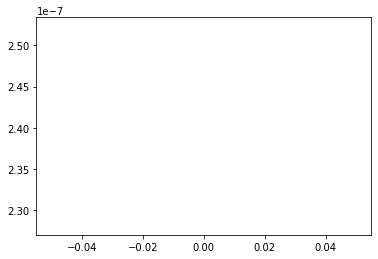

In [59]:
plt.plot(total_losses)
plt.show()

---
## Quick np save/load

In [ ]:
# np.savetxt('Results/BPR_TF/p.txt', model.p.numpy(), fmt='%f')
# np.savetxt('Results/BPR_TF/q.txt', model.q.numpy(), fmt='%f')


p = np.loadtxt(path + 'Results/BPR_TF/p.txt', dtype=float)
q = np.loadtxt(path + 'Results/BPR_TF/q.txt', dtype=float)

# Evaluate Model

---
## Rank items per user

In [ ]:
def rank_predictions(model, test_set, rank_at):
    import eval_rank_bpr
    
    s = time.time()
    users = test_set.user_id.unique()
    items = test_set.item_id.unique()
    test_user_items = test_set.groupby('user_id')['item_id'].apply(list)
    ranked_df = pd.DataFrame(columns=['pred_items_ranked', 'true_id'], index=users)
    
    pred_items_ranked = []
    true_items_list = []

    for u in users:
        user_item_pred_score = []
        true_items = []
        for true_item in test_user_items.loc[u]:
            true_items.append(true_item)

        predictions = np.dot(model['p'][u], model['q'].T)
        ids = np.argpartition(predictions, -rank_at)[-rank_at:]
        best_ids = np.argsort(predictions[ids])[::-1]
        best = ids[best_ids]

        pred_items_ranked.append(best)
        true_items_list.append(true_items)

    ranked_df['pred_items_ranked'] = pred_items_ranked
    ranked_df['true_id'] = true_items_list

    print('Ranking time:', round(time.time() - s,2))
    
    return ranked_df

In [ ]:
def get_metrics(ranked_df, steps, max_rank):
    s = time.time()
    ranks_at = [1] + [i for i in range(steps, max_rank + steps, steps)]
    hitcounts = []
    recs_at = []
    precs_at = []
    metrics = pd.DataFrame(columns=['rank_at', 'hitcounts', 'recall', 'precision'])
    for rank in ranks_at:
        hitcount = 0
        for i, row in ranked_df.iterrows():
            hitcount +=  len(set(row['true_id']) & set(row['pred_items_ranked'][:rank]))

        prec_at = hitcount / rank / len(ranked_df)
        rec_at = hitcount / len(ranked_df.iloc[0]['true_id']) / len(ranked_df)

        hitcounts.append(hitcount)                     
        recs_at.append(rec_at)
        precs_at.append(prec_at)

    metrics['rank_at'] = ranks_at
    metrics['hitcounts'] = hitcounts
    metrics['recall'] = recs_at
    metrics['precision'] = precs_at
    print('Obtaining metrics time:', round(time.time() - s,2))
    return metrics

## Ranking and Metrics

In [ ]:
len(test_set.user_id.unique())

In [ ]:
result = {'p':model.p.numpy(), 'q':model.q.numpy()}

In [ ]:
rank_at = 20
ranked_df = rank_predictions(result, test_set, rank_at)

steps = 5
metrics = get_metrics(ranked_df, steps, rank_at)

In [ ]:
metrics

In [ ]:
steps = 5
ranks_at = [1] + [i for i in range(steps, rank_at + steps, steps)]
ranks_at

In [ ]:
ranked_df.head()

---
## Calc Hits@, Rec@ and Prec@

In [ ]:
hitcounts = []
recs_at = []
precs_at = []
bpr_tf = pd.DataFrame(columns=['rank_at', 'hitcounts', 'recall', 'precision'])
for rank in ranks_at:
    hitcount = 0
    for u in ranked_df.index:
        hitcount +=  len(set(ranked_df.loc[u]['true_id']) & set(ranked_df.loc[u]['pred_items_ranked'][:rank]))
                    
    prec_at = hitcount / rank / len(ranked_df)
    rec_at = hitcount / len(ranked_df.iloc[0]['true_id']) / len(ranked_df)
    
    print('rank_at:', rank, '  Hits:', hitcount)
    hitcounts.append(hitcount)                     
    recs_at.append(rec_at)
    precs_at.append(prec_at)

bpr_tf['rank_at'] = ranks_at
bpr_tf['hitcounts'] = hitcounts
bpr_tf['recall'] = recs_at
bpr_tf['precision'] = precs_at
bpr_tf

---
## Store Results

In [ ]:
result_path = 'Results/BPR_TF/'
bpr_tf.to_pickle(path + result_path + file_name + '_bpr_tf_res')

In [ ]:
bpr_tf

In [ ]:
pd.read_pickle(path + result_path + 'ml_07m' + '_bpr_tf_res')